In [1]:
import sys
import os
import logging
import ast
import re

import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', 100)
pd.set_option('display.max_colwidth', None)
from scipy import stats
from scipy.special import rel_entr

from tqdm.notebook import tqdm
from copy import deepcopy

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
plt.style.use('default')

In [2]:
def set_style(fsz=14):
    sns.set_context("paper")
    plt.rc('font', family='Linux Libertine')
    sns.set_style("ticks", {"xtick.major.size": 3, "ytick.major.size": 3})
    
    plt.rc('font', size=fsz, family='Linux Libertine')
    plt.rc('axes', titlesize=fsz)
    plt.rc('axes', labelsize=fsz)
    plt.rc('xtick', labelsize=fsz)
    plt.rc('ytick', labelsize=fsz)
    plt.rc('legend', fontsize=fsz)
    plt.rc('figure', titlesize=fsz)
    plt.rcParams["mathtext.fontset"] = "dejavuserif"
    plt.rcParams['hatch.linewidth'] = 2
    
def set_size(fig, width=6, height=4):
    fig.set_size_inches(width, height)
    plt.tight_layout()
    
VIZ_DIR = "/scratchNVM0/ndhuynh/data/figs/"
def save_fig(fig, filename):
    fig.savefig(VIZ_DIR + filename, dpi=300, format='pdf', bbox_inches='tight')

In [3]:
sys.path.insert(1, '/scratchNVM0/ndhuynh/endure/endure')
from data.data_provider import DataProvider
from data.data_exporter import DataExporter
from robust.workload_uncertainty import WorkloadUncertainty
from lsm_tree.cost_function import CostFunction
from lsm_tree.nominal import NominalWorkloadTuning
from jobs.sample_uncertain_workloads import SampleUncertainWorkloads

config = DataProvider.read_config('/scratchNVM0/ndhuynh/endure/endure/config/robust-lsm-trees.yaml')
de = DataExporter(config)
dp = DataProvider(config)

In [18]:
to_array = lambda w: [w['z0'], w['z1'], w['q'], w['w']]
w0s = [
    {'z0': 0.25, 'z1': 0.25, 'q': 0.25, 'w': 0.25},
    {'z0': 0.97, 'z1': 0.01, 'q': 0.01, 'w': 0.01},
]
size_ratios = [2, 5]
bpes = [3, 7]
leveling = [True, False, False]
w_hats = SampleUncertainWorkloads(config).get_uncertain_samples(10000)

lsm_config = config['lsm_tree_config']
w0 = deepcopy(w0s[1])

In [19]:
cf = CostFunction(**lsm_config, **w0s[0])
costs = deepcopy(w_hats)

data = {}
for bpe, T, level in zip(bpes, size_ratios, leveling):
    data[T] = [w0] + deepcopy(w_hats) 
    for idx, wl in enumerate(data[T]):
        cf.z0 = wl['z0']
        cf.z1 = wl['z1']
        cf.q = wl['q']
        cf.w = wl['w']
        cf.is_leveling_policy = level
        cost = cf.calculate_cost(bpe, T)
        data[T][idx]['cost'] = cost
        d = np.sum(rel_entr(to_array(wl), to_array(w0)))
#         print(f'D_KL({to_array(wl)}, {to_array(w0)}) = {rel_entr(to_array(wl), to_array(w0))} = {d}')
        data[T][idx]['dist'] = np.sum(rel_entr(to_array(wl), to_array(w0)))
        
    data[T] = pd.DataFrame(data[T])
    data[T] = data[T].sort_values(by='dist').reset_index()

In [22]:
left, right, steps = 0, 4, 25
line = np.linspace(left, right, steps)
df_max = {}
df_min = {}
for T in size_ratios:
    df = data[T]
    max_idxs = []
    min_idxs = []
    for idx in range(0, len(line) - 1):
        leftpt, rightpt = line[idx], line[idx + 1]
        max_idx = df[(df.dist > leftpt) & (df.dist < rightpt)]['cost'].idxmax()
        min_idx = df[(df.dist > leftpt) & (df.dist < rightpt)]['cost'].idxmin()
        max_idxs.append(max_idx)
        min_idxs.append(min_idx)
    df_max[T] = df.loc[max_idxs].reset_index()
    df_min[T] = df.loc[min_idxs].reset_index()

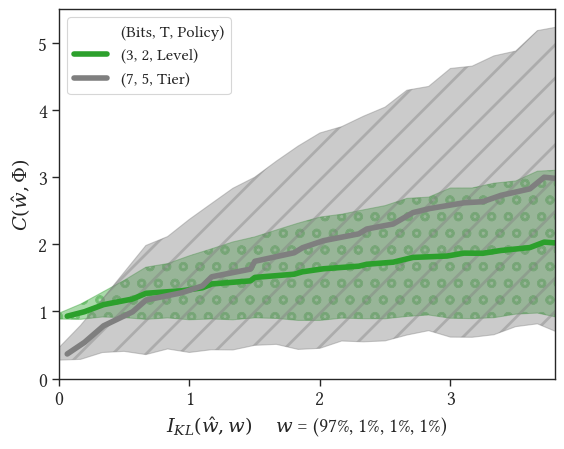

In [28]:
set_style()
fig, ax = plt.subplots()
ax.plot(0, 0, color='white', label='(Bits, T, Policy)')
for bpe, T, level, hatch, color in zip(bpes, size_ratios, leveling, ['o', '/', '--'], ['tab:green', 'tab:gray', 'tab:green']):
    x, y, = data[T]['dist'], data[T]['cost']
#     x, y, = dfs[T]['dist'], dfs[T]['cost']
    p = np.polynomial.polynomial.Polynomial.fit(x, y, 1)
#     ax.plot(x, p(x), label=f'({bpe}, {T}, {"Level" if level else "Tier"})', color=color)
    ax.fill_between(np.linspace(left, right, steps)[:-1], df_min[T]['cost'], df_max[T]['cost'], alpha=0.4, hatch=hatch, color=color)
    ax.plot(df_min[T]['dist'], (df_min[T]['cost'] + df_max[T]['cost']) / 2, label=f'({bpe}, {T}, {"Level" if level else "Tier"})', lw=4, color=color)
#     ax.scatter(df_min[T]['dist'], df_min[T]['cost'], alpha=1, s=5, color=color)
#     ax.scatter(df_max[T]['dist'], df_max[T]['cost'], alpha=1, s=5, color=color)
ax.set_xlabel('$I_{KL}(\hat{{w}}, w) \quad$ $w$ = (97%, 1%, 1%, 1%)')
ax.set_ylabel('$C(\hat{w}, \Phi)$')
ax.set_ylim(bottom=0)
ax.set_xlim(0, 3.8)
ax.set_xticks([0, 1, 2, 3])
ax.legend(loc='upper left', fontsize=12)

In [ ]:
 df_min[T]['cost'] + df_min[T]['cost']